# About
This notebook is a exploratory data analysis of the Walmart dataset used in the M5 forecasting competition.

## Dataset
The M5 competition is the latest of five recurring forecast competitions created by forecasting expert, Spyros Makridakis, as a way of measuring and comparing traditional statistacal forecasting methods vs new non-traditional methods such as ML.

From [the M5 website](https://mofc.unic.ac.cy/m5-competition/): 

<blockquote>The aim of the M5 Competition is similar to the previous four: that is to identify the most appropriate method(s) for different types of situations requiring predictions and making uncertainty estimates. Its ultimate purpose is to advance the theory of forecasting and improve its utilization by business and non-profit organizations. Its other goal is to compare the accuracy/uncertainty of ML and DL methods vis-à-vis those of standard statistical ones, and assess possible improvements versus the extra complexity and higher costs of using the various methods.</blockquote>

The dataset consists of five seperate 'csv' files which contain all of the data offered for the competition. In this particular competition, additional data is also allowed to be used.


# Imports
Notebook dependencies

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

# Setting up environment
Copying files into the Colab environment

In [8]:
!cp /content/drive/My\ Drive/m5/m5-forecasting-accuracy.zip /content/

In [9]:
!unzip /content/m5-forecasting-accuracy.zip

Archive:  /content/m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         


# Library

## reduce_mem_usage

In [189]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# calendar.csv
- *weekday*, *wday*, *month*, and *year* are all derived from the date
- *wm_yr_wk* is a unique id for the week
- *d* is the number of the day for each date in the dataset. Has corresponding column in the sales data that can be used as a key for join
- *event_name_* and *event_type_* represent whether or not a special event occurred on that day
- *snap_* indicates whether or not SNAP purchases were allowed on that day

In [19]:
calendar_df = pd.read_csv('calendar.csv')

In [190]:
calendar_df = reduce_mem_usage(calendar_df)

Mem. usage decreased to  0.12 Mb (41.9% reduction)


In [191]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [66]:
calendar_df.isna().sum()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

## Date Features

### date
- The dataset begins on January 29, 2011, and ends on June 19, 2016. This means there are 1,969 days included in the dataset.


In [28]:
print(f"Number of unique dates: {calendar_df['date'].nunique()}")
print(f"Total number of entries: {calendar_df.shape[0]}")
print(f"Starting Date: {calendar_df.iloc[0]['date']}")
print(f"Ending Date: {calendar_df.iloc[-1]['date']}")

Number of unique dates: 1969
Total number of entries: 1969
Starting Date: 2011-01-29
Ending Date: 2016-06-19


### wm_yr_wk
- Unique number for identifying which 'week' the datapoint belongs to
- No missing values

In [39]:
print(f"Number of unique values: {calendar_df['wm_yr_wk'].nunique()}")
print(f"Number of days in dataset divide by seven: {calendar_df.shape[0]/7}")
print(f"Missing: {calendar_df['wm_yr_wk'].isna().sum()}")

Number of unique values: 282
Number of days in dataset divide by seven: 281.2857142857143
Missing: 0


### weekday
- String indicating which day of the week it is, e.g. 'Sunday', 'Monday'

In [45]:
print(f"Days included: {calendar_df['weekday'].unique()}")

Days included: ['Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday']


### wday
- Numerical version of the *weekday* feature
- We can see that the *wday* value of '1' corresponds to the *weekday* value of 'Saturday'

In [49]:
calendar_df[['weekday', 'wday']].head(7)

,weekday,wday
0,Saturday,1
1,Sunday,2
2,Monday,3
3,Tuesday,4
4,Wednesday,5
5,Thursday,6
6,Friday,7


In [50]:
calendar_df[['weekday', 'wday']].tail(7)

,weekday,wday
1962,Monday,3
1963,Tuesday,4
1964,Wednesday,5
1965,Thursday,6
1966,Friday,7
1967,Saturday,1
1968,Sunday,2


### month
- The number of the month, with January being represented by '1'

In [54]:
calendar_df[['date', 'month']].head()

,date,month
0,2011-01-29,1
1,2011-01-30,1
2,2011-01-31,1
3,2011-02-01,2
4,2011-02-02,2


### year
- 2012 is a leap year, as there are 366 days

In [56]:
print(f"Years represented: {calendar_df['year'].unique()}")

Years represented: [2011 2012 2013 2014 2015 2016]


In [182]:
for year in calendar_df['year'].unique():
    print(f"{calendar_df[calendar_df['year'] == year].shape[0]} days in the year {year}")

337 days in the year 2011
366 days in the year 2012
365 days in the year 2013
365 days in the year 2014
365 days in the year 2015
171 days in the year 2016


### d
- Key for indexing dataset by number, 1-1969


In [65]:
print(f"Contains values from {calendar_df['d'].values[0]} to {calendar_df['d'].values[-1]}")
print(f"{calendar_df['d'].nunique()} unique values")

Contains values from d_1 to d_1969
1969 unique values


## Event Features
The event features contain indicators for whether or not a special event occurred on the given day.

There are two different event columns, for the rare occurrence that two events fall on the same day.

### event_name_1
- The first year is missing all the January events, while the last year is missing all the events after June 19 because that is when the data is cutoff
- Missing events are in the event_name_2

In [109]:
all_event_names = calendar_df['event_name_1'].unique()
print(f"{calendar_df['event_name_1'].isna().sum()} Nan values")
print(f"Unique Values ({calendar_df['event_name_1'].nunique()}): {all_event_names}")

1807 Nan values
Unique Values (30): [nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']


In [126]:
for year in calendar_df['year'].unique():
    events = calendar_df[calendar_df['year'] == year]['event_name_1']
    print(f"{'*'*10}-{year}-{'*'*10}")
    print(f"Number of holidays represented: {events.nunique()}")
    print(f"Events missing:\n{[name for name in all_event_names if name not in events.unique() ]}\n")

**********-2011-**********
Number of holidays represented: 26
Events missing:
[nan, 'NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter']

**********-2012-**********
Number of holidays represented: 30
Events missing:
[nan]

**********-2013-**********
Number of holidays represented: 29
Events missing:
[nan, 'Cinco De Mayo']

**********-2014-**********
Number of holidays represented: 28
Events missing:
[nan, 'OrthodoxEaster', "Father's day"]

**********-2015-**********
Number of holidays represented: 30
Events missing:
[nan]

**********-2016-**********
Number of holidays represented: 19
Events missing:
[nan, "Father's day", 'IndependenceDay', 'Eid al-Fitr', 'LaborDay', 'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay', 'Thanksgiving', 'Christmas', 'Chanukah End']



### event_type_1
- Type of event if any on the specific day

In [89]:
print(f"{calendar_df['event_type_1'].isna().sum()} Nan values")
print(f"Unique Values ({calendar_df['event_type_1'].nunique()}): {calendar_df['event_type_1'].unique()}")
calendar_df.dropna()[['event_name_1', 'event_type_1']]

1807 Nan values
Unique Values (4): [nan 'Sporting' 'Cultural' 'National' 'Religious']


,event_name_1,event_type_1
85,OrthodoxEaster,Religious
827,OrthodoxEaster,Religious
1177,Easter,Cultural
1233,NBAFinalsEnd,Sporting
1968,NBAFinalsEnd,Sporting


In [155]:
calendar_df[calendar_df['year'] == 2014].groupby(['year', 'month', 'event_type_1', 'event_name_1'])[['date']].sum()

date
year month event_type_1 event_name_1                   
2014 1     National     MartinLutherKingDay  2014-01-20
                        NewYear              2014-01-01
           Religious    OrthodoxChristmas    2014-01-07
     2     Cultural     ValentinesDay        2014-02-14
           National     PresidentsDay        2014-02-17
           Sporting     SuperBowl            2014-02-02
     3     Cultural     StPatricksDay        2014-03-17
           Religious    LentStart            2014-03-05
                        LentWeek2            2014-03-12
                        Purim End            2014-03-16
     4     Cultural     Easter               2014-04-20
           Religious    Pesach End           2014-04-22
     5     Cultural     Cinco De Mayo        2014-05-05
                        Mother's day         2014-05-11
           National     MemorialDay          2014-05-26
     6     Religious    Ramadan starts       2014-06-29
           Sporting     NBAFinalsEnd         2014-06-15
                        NBAFinalsStart       2014-06-05
     7     National     IndependenceDay      2014-07-04
           Religious    Eid al-Fitr          2014-07-29
     9     National     LaborDay             2014-09-01
     10    Cultural     Halloween            2014-10-31
           National     ColumbusDay          2014-10-13
           Religious    EidAlAdha            2014-10-04
     11    National     Thanksgiving         2014-11-27
                        VeteransDay          2014-11-11
     12    National     Christmas            2014-12-25
           Religious    Chanukah End         2014-12-24

In [162]:
calendar_df[calendar_df['date'] == '2014-06-15']

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1233,2014-06-15,11420,Sunday,2,6,2014,d_1234,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1


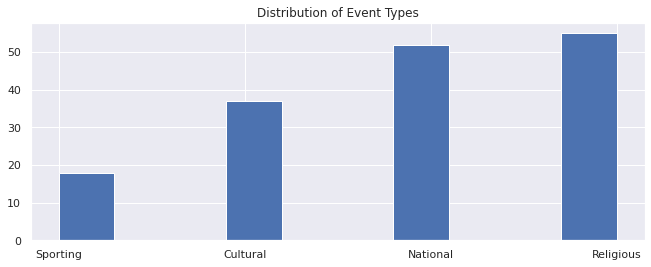

In [129]:
calendar_df['event_type_1'].hist()
plt.title('Distribution of Event Types');

### event_name_2
- Contains the events name if a given day already contains an event_name_1


In [165]:
for year in calendar_df['year'].unique():
    events = calendar_df[calendar_df['year'] == year]['event_name_2']
    print(f"{'*'*10}-{year}-{'*'*10}")
    print(f"Number of holidays represented: {events.nunique()}")
    print(f"Events:\n{[name for name in all_event_names if name in events.unique() ]}\n")

**********-2011-**********
Number of holidays represented: 1
Events:
['Easter']

**********-2012-**********
Number of holidays represented: 0
Events:
[]

**********-2013-**********
Number of holidays represented: 1
Events:
['Cinco De Mayo']

**********-2014-**********
Number of holidays represented: 2
Events:
['OrthodoxEaster', "Father's day"]

**********-2015-**********
Number of holidays represented: 0
Events:
[]

**********-2016-**********
Number of holidays represented: 1
Events:
["Father's day"]



### event_type_2


In [166]:
print(f"{calendar_df['event_type_1'].isna().sum()} Nan values")
print(f"Unique Values ({calendar_df['event_type_2'].nunique()}): {calendar_df['event_type_2'].unique()}")
calendar_df.dropna()[['event_name_2', 'event_type_2']]

1807 Nan values
Unique Values (2): [nan 'Cultural' 'Religious']


,event_name_2,event_type_2
85,Easter,Cultural
827,Cinco De Mayo,Cultural
1177,OrthodoxEaster,Religious
1233,Father's day,Cultural
1968,Father's day,Cultural


## Snap Features
One column for each state, indicates whether or not SNAP is allowed for the date.

Each state accepts SNAP that same amount of days per year.

### snap_CA

In [186]:
state = 'CA'
for year in calendar_df['year'].unique():
    year_df = calendar_df[calendar_df['year'] == year][f'snap_{state}']
    print(f"SNAP days in {state} for {year}: {year_df.sum()} days out of {year_df.shape[0]}")

SNAP days in CA for 2011: 110 days out of 337
SNAP days in CA for 2012: 120 days out of 366
SNAP days in CA for 2013: 120 days out of 365
SNAP days in CA for 2014: 120 days out of 365
SNAP days in CA for 2015: 120 days out of 365
SNAP days in CA for 2016: 60 days out of 171


### snap_TX


In [179]:
state = 'TX'
for year in calendar_df['year'].unique():
    year_df = calendar_df[calendar_df['year'] == year][f'snap_{state}']
    print(f"SNAP days in {state} for {year}: {year_df.sum()} days out of {year_df.shape[0]}")

SNAP days in TX for 2011: 110 days out of 337
SNAP days in TX for 2012: 120 days out of 366
SNAP days in TX for 2013: 120 days out of 365
SNAP days in TX for 2014: 120 days out of 365
SNAP days in TX for 2015: 120 days out of 365
SNAP days in TX for 2016: 60 days out of 171


### snap_WI

In [180]:
state = 'WI'
for year in calendar_df['year'].unique():
    year_df = calendar_df[calendar_df['year'] == year][f'snap_{state}']
    print(f"SNAP days in {state} for {year}: {year_df.sum()} days out of {year_df.shape[0]}")

SNAP days in WI for 2011: 110 days out of 337
SNAP days in WI for 2012: 120 days out of 366
SNAP days in WI for 2013: 120 days out of 365
SNAP days in WI for 2014: 120 days out of 365
SNAP days in WI for 2015: 120 days out of 365
SNAP days in WI for 2016: 60 days out of 171


# sales_train_validation.csv
The first of two dataframes which track the number of sales for a given item over the course of 1913 days.

We can disregard this file and use the updated one that was released later on in the competition.

# sales_train_evaluation.csv


The next data frame: sales_train_validation, extends those days to 1941.

In [212]:
sales_train_evaluation_df = reduce_mem_usage(pd.read_csv('sales_train_evaluation.csv'))

Mem. usage decreased to 96.13 Mb (78.8% reduction)


In [213]:
sales_train_evaluation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int16(1317), int8(624), object(6)
memory usage: 96.1+ MB


In [214]:
sales_train_evaluation_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


## Hierarchical Features
The items to be predicted are presented in a hierchical format.

### id
Unique identifier, created with item_id, store_id, and '_evaluation'.

In [222]:
print(f"Unique: {sales_train_evaluation_df['id'].nunique()}/{sales_train_evaluation_df.shape[0]}")
sales_train_evaluation_df.head()[['id', 'item_id', 'store_id']]

Unique: 30490/30490


,id,item_id,store_id
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,CA_1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,CA_1
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,CA_1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,CA_1
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,CA_1


### item_id
Represents the individual items id.

3,049 different unique items.

In [238]:
print(f"Unique values: {sales_train_evaluation_df['item_id'].nunique()}")
sales_train_evaluation_df.sample(5)['item_id']

Unique values: 3049


20926        FOODS_3_408
1434     HOUSEHOLD_2_339
16108    HOUSEHOLD_1_305
24865      HOBBIES_2_058
8031         FOODS_2_107
Name: item_id, dtype: object

### dept_id

In [242]:
print(f"Number of Unique: {sales_train_evaluation_df['dept_id'].nunique()}")
print(f"Unique Values:\n{sales_train_evaluation_df['dept_id'].unique()}")

Number of Unique: 7
Unique Values:
['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']


### cat_id

In [232]:
print(f"Number of Unique: {sales_train_evaluation_df['cat_id'].nunique()}")
print(f"Unique Values:\n{sales_train_evaluation_df['cat_id'].unique()}")

Number of Unique: 3
Unique Values:
['HOBBIES' 'HOUSEHOLD' 'FOODS']


### store_id

In [233]:
print(f"Number of Unique: {sales_train_evaluation_df['store_id'].nunique()}")
print(f"Unique Values:\n{sales_train_evaluation_df['store_id'].unique()}")

Number of Unique: 10
Unique Values:
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']


### state_id

In [235]:
print(f"Number of Unique: {sales_train_evaluation_df['state_id'].nunique()}")
print(f"Unique Values:\n{sales_train_evaluation_df['state_id'].unique()}")

Number of Unique: 3
Unique Values:
['CA' 'TX' 'WI']


# sample_submission.csv
Example of the expected submission format.

It is expected to submit 28 day predictions for both the validation set as well as the evaluation set.

However, since the validation set has been released, it contains the actual values for the evaluation predictions.

This means the first half an be filled in with the actual demand, while the second half will be filled in with the final 28 day predictions.

In [203]:
sample_submission_df = reduce_mem_usage(pd.read_csv('sample_submission.csv'))

Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [237]:
sample_submission_df.shape

(60980, 29)

In [236]:
sample_submission_df.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# sell_prices.csv

In [204]:
sell_prices_df = reduce_mem_usage(pd.read_csv('sell_prices.csv'))

Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [244]:
sell_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int16  
 3   sell_price  float16
dtypes: float16(1), int16(1), object(2)
memory usage: 130.5+ MB


In [246]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [248]:
sell_prices_df.isna().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64